# Set up database infrastructure

In [76]:
from sqlalchemy import create_engine
from sqlalchemy import asc, desc

In [2]:
from sqlalchemy.orm import Session

In [3]:
from sqlalchemy.ext.automap import automap_base

In [5]:
engine = create_engine('sqlite:///measurements.db')

In [6]:
Base = automap_base()
Base.prepare(engine, reflect=True)

In [35]:
Project = Base.classes.projects
Password = Base.classes.passwords
Salt = Base.classes.salts
Klen = Base.classes.klens
Round = Base.classes.rounds
Block = Base.classes.blocks
Column_ = Base.classes.columns
Sponge = Base.classes.sponges
TimeCost = Base.classes.tcosts
MemoryCost = Base.classes.mcosts

In [13]:
Result = Base.classes.results

In [8]:
session = Session(engine)

# Set up plotting infrastructure

In [15]:
import matplotlib.pyplot as plt

In [170]:
def plot_tcost(project, password, salt, klen, rounds, blocks, columns, sponge, mcost):
    project_id = session.query(Project).filter_by(project=project).one().id
    password_id = session.query(Password).filter_by(password=password).one().id
    salt_id = session.query(Salt).filter_by(salt=salt).one().id
    klen_id = session.query(Klen).filter_by(klen=klen).one().id
    round_id = session.query(Round).filter_by(rounds=rounds).one().id
    block_id = session.query(Block).filter_by(blocks=blocks).one().id
    column_id = session.query(Column_).filter_by(columns=columns).one().id
    sponge_id = session.query(Sponge).filter_by(sponge=sponge).one().id
    mcost_id = session.query(MemoryCost).filter_by(mcost=mcost).one().id
    
    data = [
        (result[1].tcost, result[0].elapsed, result[0].pss_mem, result[0].uss_mem)
        for result in session.query(
            Result, TimeCost
        ).filter_by(
            tcost_id=TimeCost.id
        ).filter_by(
            project_id=project_id
            , password_id=password_id
            , salt_id=salt_id
            , klen_id=klen_id
            , round_id=round_id
            , block_id=block_id
            , column_id=column_id
            , sponge_id=sponge_id
            , mcost_id=mcost_id
        ).order_by(asc(TimeCost.tcost))
    ]
    
    return data

In [164]:
def plot_mcost(project, password, salt, klen, rounds, blocks, columns, sponge, tcost):
    project_id = session.query(Project).filter_by(project=project).one().id
    password_id = session.query(Password).filter_by(password=password).one().id
    salt_id = session.query(Salt).filter_by(salt=salt).one().id
    klen_id = session.query(Klen).filter_by(klen=klen).one().id
    round_id = session.query(Round).filter_by(rounds=rounds).one().id
    block_id = session.query(Block).filter_by(blocks=blocks).one().id
    column_id = session.query(Column_).filter_by(columns=columns).one().id
    sponge_id = session.query(Sponge).filter_by(sponge=sponge).one().id
    tcost_id = session.query(TimeCost).filter_by(tcost=tcost).one().id
    
    data = [
        (result[1].mcost, result[0].elapsed, result[0].pss_mem, result[0].uss_mem)
        for result in session.query(
            Result, MemoryCost
        ).filter_by(
            mcost_id=MemoryCost.id
        ).filter_by(
            project_id=project_id
            , password_id=password_id
            , salt_id=salt_id
            , klen_id=klen_id
            , round_id=round_id
            , block_id=block_id
            , column_id=column_id
            , sponge_id=sponge_id
            , tcost_id=tcost_id
        ).order_by(asc(MemoryCost.mcost))
    ]
    
    return data

In [165]:
data = plot_mcost('lyra2-c', 'password', 'salt', 10, rounds=12, blocks=12, columns=256, sponge='blake2b', tcost=100)

# Draw 2d-comparison plots

In [245]:
data0 = plot_tcost('lyra2-c', 'password', 'salt', 10, rounds=12, blocks=12, columns=256, sponge='blake2b', mcost=20)
data1 = plot_tcost('lyra2-java', 'password', 'salt', 10, rounds=12, blocks=12, columns=256, sponge='blake2b', mcost=20)
data2 = plot_tcost('lyra2-c', 'password', 'salt', 10, rounds=12, blocks=12, columns=256, sponge='blamka', mcost=20)
data3 = plot_tcost('lyra2-java', 'password', 'salt', 10, rounds=12, blocks=12, columns=256, sponge='blamka', mcost=20)

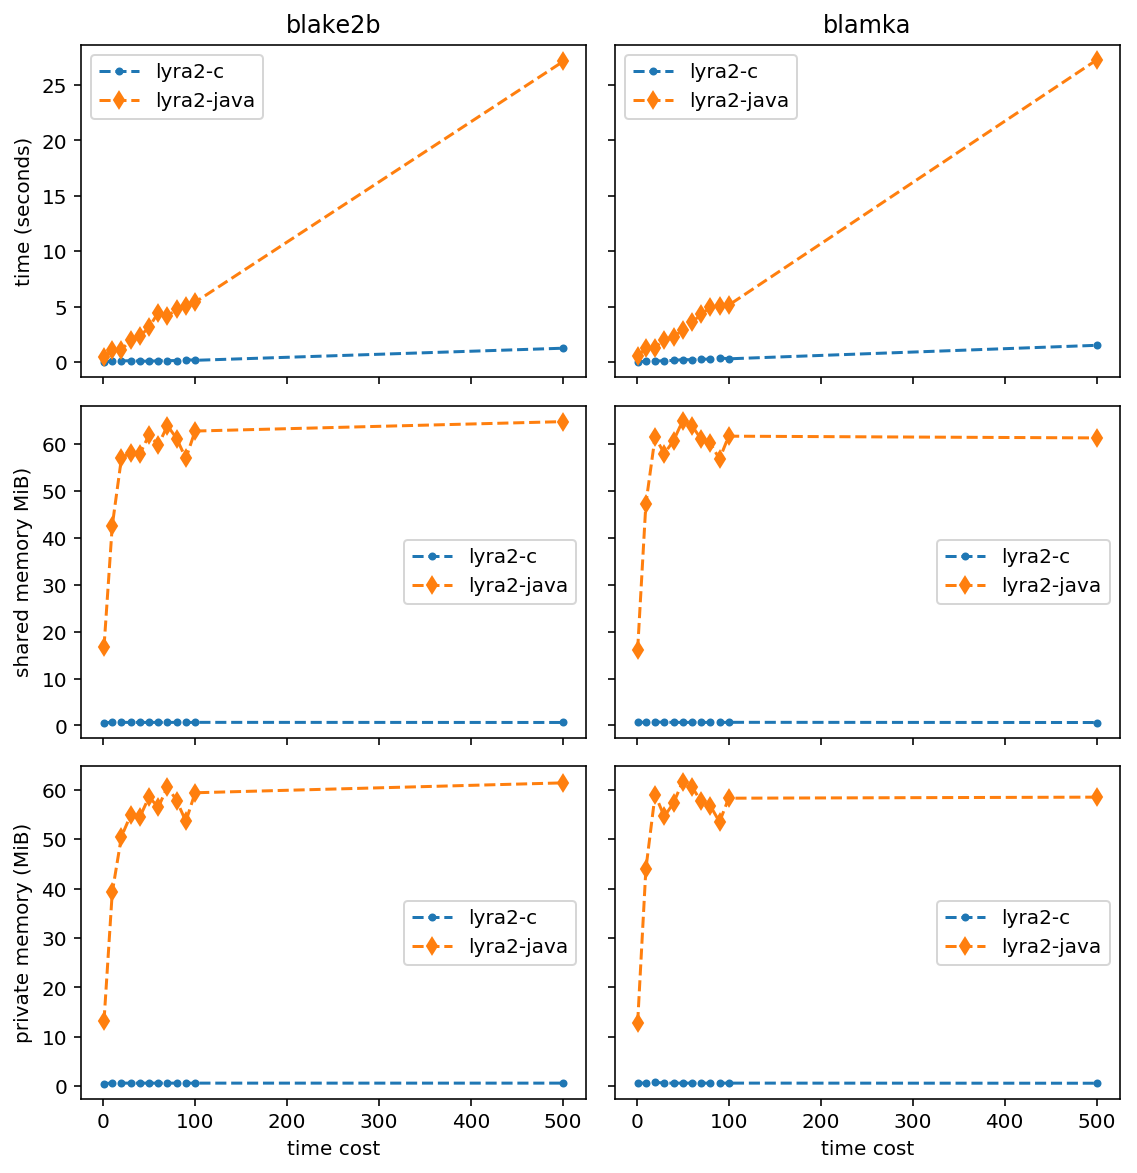

In [267]:
fig = plt.figure(figsize=(8, 8.25), dpi=144)

ax1 = plt.subplot2grid((3, 2), (0, 0))
ax2 = plt.subplot2grid((3, 2), (0, 1),             sharey=ax1)
ax3 = plt.subplot2grid((3, 2), (1, 0), sharex=ax1)
ax4 = plt.subplot2grid((3, 2), (1, 1), sharex=ax2, sharey=ax3)
ax5 = plt.subplot2grid((3, 2), (2, 0), sharex=ax1)
ax6 = plt.subplot2grid((3, 2), (2, 1), sharex=ax2, sharey=ax5)

ax1.set_title('blake2b')
ax1.plot([d[0] for d in data0], [d[1] for d in data0], '.--', label='lyra2-c')
ax1.plot([d[0] for d in data1], [d[1] for d in data1], 'd--', label='lyra2-java')
ax1.set_ylabel('time (seconds)')
ax1.legend(loc='upper left')

ax2.set_title('blamka')
ax2.plot([d[0] for d in data2], [d[1] for d in data2], '.--', label='lyra2-c')
ax2.plot([d[0] for d in data3], [d[1] for d in data3], 'd--', label='lyra2-java')
ax2.legend(loc='upper left')

denom = 1024 * 1024

ax3.plot([d[0] for d in data0], [d[2] / denom for d in data0], '.--', label='lyra2-c')
ax3.plot([d[0] for d in data1], [d[2] / denom for d in data1], 'd--', label='lyra2-java')
ax3.set_ylabel('shared memory MiB)')
ax3.legend(loc='center right')

ax4.plot([d[0] for d in data2], [d[2] / denom for d in data2], '.--', label='lyra2-c')
ax4.plot([d[0] for d in data3], [d[2] / denom for d in data3], 'd--', label='lyra2-java')
ax4.legend(loc='center right')

ax5.plot([d[0] for d in data0], [d[3] / denom for d in data0], '.--', label='lyra2-c')
ax5.plot([d[0] for d in data1], [d[3] / denom for d in data1], 'd--', label='lyra2-java')
ax5.set_xlabel('time cost')
ax5.set_ylabel('private memory (MiB)')
ax5.legend(loc='center right')

ax6.plot([d[0] for d in data2], [d[3] / denom for d in data2], '.--', label='lyra2-c')
ax6.plot([d[0] for d in data3], [d[3] / denom for d in data3], 'd--', label='lyra2-java')
ax6.set_xlabel('time cost')
ax6.legend(loc='center right')

plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax4.get_xticklabels(), visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax4.get_yticklabels(), visible=False)
plt.setp(ax6.get_yticklabels(), visible=False)

plt.tight_layout()
plt.show()

In [270]:
data0 = plot_mcost('lyra2-c', 'password', 'salt', 10, rounds=12, blocks=12, columns=256, sponge='blake2b', tcost=10)
data1 = plot_mcost('lyra2-java', 'password', 'salt', 10, rounds=12, blocks=12, columns=256, sponge='blake2b', tcost=10)
data2 = plot_mcost('lyra2-c', 'password', 'salt', 10, rounds=12, blocks=12, columns=256, sponge='blamka', tcost=10)
data3 = plot_mcost('lyra2-java', 'password', 'salt', 10, rounds=12, blocks=12, columns=256, sponge='blamka', tcost=10)

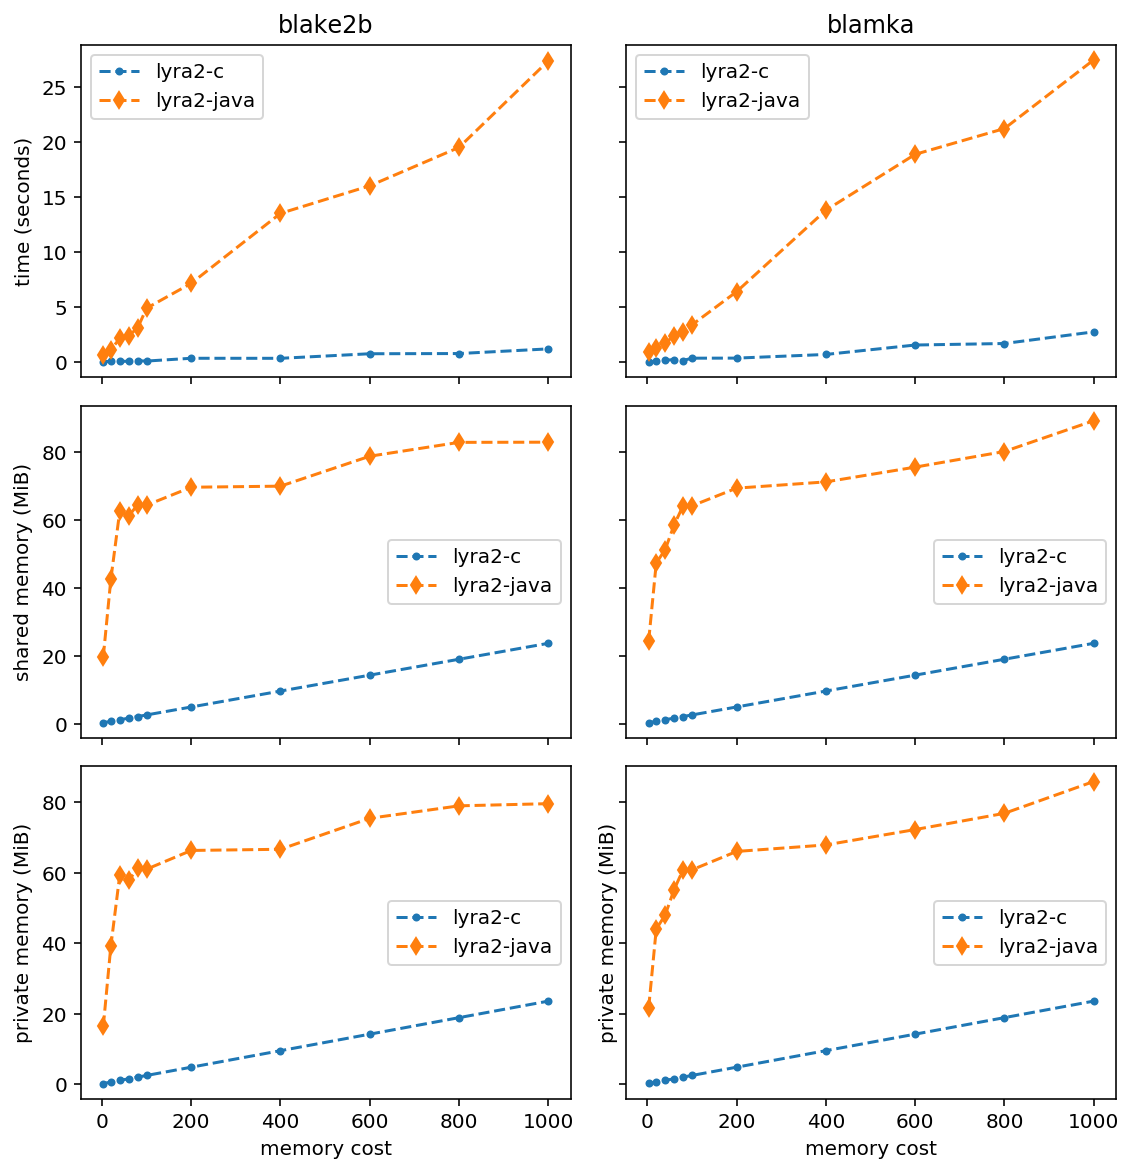

In [274]:
fig = plt.figure(figsize=(8, 8.25), dpi=144)

ax1 = plt.subplot2grid((3, 2), (0, 0))
ax2 = plt.subplot2grid((3, 2), (0, 1),             sharey=ax1)
ax3 = plt.subplot2grid((3, 2), (1, 0), sharex=ax1)
ax4 = plt.subplot2grid((3, 2), (1, 1), sharex=ax2, sharey=ax3)
ax5 = plt.subplot2grid((3, 2), (2, 0), sharex=ax1)
ax6 = plt.subplot2grid((3, 2), (2, 1), sharex=ax2, sharey=ax5)

ax1.set_title('blake2b')
ax1.plot([d[0] for d in data0], [d[1] for d in data0], '.--', label='lyra2-c')
ax1.plot([d[0] for d in data1], [d[1] for d in data1], 'd--', label='lyra2-java')
ax1.set_ylabel('time (seconds)')
ax1.legend(loc='upper left')

ax2.set_title('blamka')
ax2.plot([d[0] for d in data2], [d[1] for d in data2], '.--', label='lyra2-c')
ax2.plot([d[0] for d in data3], [d[1] for d in data3], 'd--', label='lyra2-java')
ax2.legend(loc='upper left')

denom = 1024 * 1024

ax3.plot([d[0] for d in data0], [d[2] / denom for d in data0], '.--', label='lyra2-c')
ax3.plot([d[0] for d in data1], [d[2] / denom for d in data1], 'd--', label='lyra2-java')
ax3.set_ylabel('shared memory (MiB)')
ax3.legend(loc='center right')

ax4.plot([d[0] for d in data2], [d[2] / denom for d in data2], '.--', label='lyra2-c')
ax4.plot([d[0] for d in data3], [d[2] / denom for d in data3], 'd--', label='lyra2-java')
ax4.legend(loc='center right')

ax5.plot([d[0] for d in data0], [d[3] / denom for d in data0], '.--', label='lyra2-c')
ax5.plot([d[0] for d in data1], [d[3] / denom for d in data1], 'd--', label='lyra2-java')
ax5.set_xlabel('memory cost')
ax5.set_ylabel('private memory (MiB)')
ax5.legend(loc='center right')

ax6.plot([d[0] for d in data2], [d[3] / denom for d in data2], '.--', label='lyra2-c')
ax6.plot([d[0] for d in data3], [d[3] / denom for d in data3], 'd--', label='lyra2-java')
ax6.set_xlabel('memory cost')
ax6.set_ylabel('private memory (MiB)')
ax6.legend(loc='center right')

plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax4.get_xticklabels(), visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax4.get_yticklabels(), visible=False)
plt.setp(ax6.get_yticklabels(), visible=False)

plt.tight_layout()
plt.show()